In [1]:
import ast # used for converting column values to lists post-import from csv
import re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from wordcloud import WordCloud

import spacy

from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, plot_confusion_matrix, plot_roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('data/recipes_for_preprocessing.cvs')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482279 entries, 0 to 482278
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                482279 non-null  int64 
 1   id                        482279 non-null  int64 
 2   name                      482279 non-null  object
 3   description               482279 non-null  object
 4   ingredients               482279 non-null  object
 5   ingredients_raw_str       482279 non-null  object
 6   serving_size              482279 non-null  object
 7   servings                  482279 non-null  int64 
 8   steps                     482279 non-null  object
 9   tags                      482279 non-null  object
 10  search_terms              482279 non-null  object
 11  ingredients_list          482279 non-null  object
 12  ingredients_raw_str_list  482279 non-null  object
 13  steps_list                482279 non-null  object
 14  tags

In [39]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"['slivered almonds', 'cider vinegar', 'sugar',...","['12 ounces slivered almonds', '1/4 cup ...",['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'prep

### Little side test on lenght of string - should revisit, will improve data

In [8]:
# def is_empty(x):
#     if len(x) <= 25:
#         return 1
#     else:
#         return 0

In [ ]:
# df_strings['is_empty'] = df_strings['combined'].apply(lambda x: is_empty(x))

In [ ]:
# df_strings['is_empty'].value_counts()

In [ ]:
# print(df_strings[df_strings['is_empty']==1])

In [ ]:
# df_strings['combined'].iloc[56]

In [59]:
df['combined'] = df['description'] + ' ' + df['steps']

In [65]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another...","We love grits, this is another good way to ser..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo...","Simple, easy and very tasty for when you are i..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '...",This is a good recipe for weight watchers. It ...
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'...",This is a fabulous stew that came from one of ...
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'pr

In [60]:
y = df['target']

In [69]:
X = pd.DataFrame(df['combined'], index = df.index)

In [70]:
X.head()

,combined
0,"We love grits, this is another good way to ser..."
1,"Simple, easy and very tasty for when you are i..."
2,This is a good recipe for weight watchers. It ...
3,This is a fabulous stew that came from one of ...
4,This is one of our standard holiday gift recip...


In [79]:
len(y)

482279

In [93]:
df_sample = df.sample(50000)
len(df_sample)

50000

In [97]:
df_sample.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
187279,191352,206466,Shredded Chicken and Walnut Sauce,This is from a Penzey's cooking magazine. I t...,"['boneless skinless chicken breasts', 'water',...","[""4 boneless skinless chicken breasts or...",1 (127 g),10,"['In a large pan, simmer the chicken with wate...","['time-to-make', 'course', 'main-ingredient', ...","{'healthy', 'low-carb', 'dinner', 'turkish', '...","['boneless skinless chicken breasts', 'water',...",['4 boneless skinless chicken breasts or...,"['In a large pan, simmer the chicken with wate...","['time-to-make', 'course', 'main-ingredient', ...","['dinner', 'turkish', 'healthy', 'chicken', 'l...",False,True,0,9,10,79,in a large pan simmer the chicken with water a...,"['in', 'a', 'large', 'pan', 'simmer', 'the', '...",this is from a penzeys cooking magazine i thin...,"['this', 'is', 'from', 'a', 'penzeys', 'cookin...",This is from a Penzey's cooking magazine. I t...
245863,251634,280930,Smoked Gouda Chicken,"In Summer of 99, new to CO, I caught the endin...","['boneless skinless chicken breasts', 'flour',...","[""3 boneless skinless chicken breasts, p...",1 (309 g),3,"['In a large skilled, heat up about 3 Tablespo...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'chicken'}","['boneless skinless chicken breasts', 'flour',...","['3 boneless skinless chicken breasts, p...","['In a large skilled, heat up about 3 Tablespo...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'chicken']",False,True,0,11,7,195,in a large skilled heat up about tablespoons b...,"['in', 'a', 'large', 'skilled', 'heat', 'up', ...",in summer of new to co i caught the ending of ...,"['in', 'summer', 'of', 'new', 'to', 'co', 'i',...","In Summer of 99, new to CO, I caught the endin..."
83501,85900,251709,Bone Crackers,Easy to make and very tasty halloween chips,"['flour tortillas', 'butter', 'garlic salt']","[""2 (13 1/2 ounce) packages flour tortillas...",1 (14 g),60,['Cut tortillas with a 3 1/2-inch bone-shaped ...,"['60-minutes-or-less', 'time-to-make', 'course...","{'appetizer', 'bread'}","['flour tortillas', 'butter', 'garlic salt']",['2 (13 1/2 ounce) packages flour tortillas...,['Cut tortillas with a 3 1/2-inch bone-shaped ...,"['60-minutes-or-less', 'time-to-make', 'course...","['appetizer', 'bread']",False,False,0,3,3,43,cut tortillas with a inch boneshaped cookie cu...,"['cut', 'tortillas', 'with', 'a', 'inch', 'bon...",easy to make and very tasty halloween chips,"['easy', 'to', 'make', 'and', 'very', 'tasty',...",Easy to make and very tasty halloween chips ['...
298154,305457,410348,Beef Biryani,I got this recipe from an app on my iphone. N...,"['sirloin beef', 'cumin powder', 'cardamom pow...","[""2 1/2 lbs sirloin beef (cut in 1 1/2-inc...",1 (218 g),6,"['In a plastic bag, mix flour, salt and pepper...","['course', 'cuisine', 'preparation', 'main-dis...","{'low-sodium', 'low-carb', 'indian', 'dinner',...","['sirloin beef', 'cumin powder', 'cardamom pow...",['2 1/2 lbs sirloin beef (cut in 1 1/2-inc...,"['In a plastic bag, mix flour, salt and pepper...","['course', 'cuisine', 'preparation', 'main-dis...","['low-sodium', 'dinner', 'beef', 'indian', 'lo...",False,True,0,15,8,172,in a plastic bag mix flour salt and pepper add...,"['in', 'a', 'plastic', 'bag', 'mix', 'flour', ...",i got this recipe from an app on my iphone not...,"['i', 'got', 'this', 'recipe', 'from', 'an', '...",I got this recipe from an app on my iphone. N...
96188,98664,317740,Vegan Blueberry Peach Crumble,I found this recipe online a long time ago (I ...,"['peach nectar', 'arrowroot', 'vanilla', 'peac...","["""",""1/2 cup peach nectar"",""1 teaspoon ...",1 (201 g),8,"['Preheat the oven

In [96]:
y_sample = df_sample['target']
len(y_sample)

50000

In [101]:
X_sample = pd.DataFrame(df_sample['combined'], index = df_sample.index)

In [35]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X,y)
y_res.value_counts()

0    98067
1    98067
Name: target, dtype: int64

In [104]:
X_sample_rus, y_sample_rus = rus.fit_resample(X_sample, y_sample)
y_sample_rus.value_counts()

0    10201
1    10201
Name: target, dtype: int64

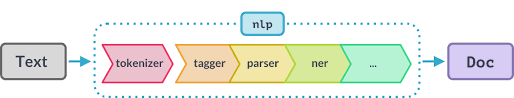

above from spacy documentation and process we'll emulate below
https://spacy.io/usage/processing-pipelines

# Tokenization 

In [105]:
nlp = spacy.load('en_core_web_sm')
stops = stopwords.words("english")

nlp

In [106]:
# lovely little function I found as the top answer here: 
# https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy

def normalize(comment, lowercase):# remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
#         if lemma:
#             if not remove_stopwords or (remove_stopwords and lemma not in stops):
        lemmatized.append(lemma)
    return " ".join(lemmatized)


In [ ]:


#sample
x = 'Having a cat can mean different things to different people. Some want a cat to cuddle and sit on their laps; others are happy to live with a very independent cat which spends most of its time outside and doesn’t want too much human interaction.'
#creating doc object containing our token features
doc = nlp(x)

#Creating and updating our list of tokens using list comprehension 
tokens = [token.text for token in doc]
print(tokens)

In [ ]:
x = "Embracing and analyzing self failures (of however multitude) is a virtue of nobelmen. Not."
prosx = nlp(x)
prosx

In [ ]:
# lemmatized = list()

# for word in doc:
#         lemma = word.lemma_.strip()
# #         if lemma:
# #             if not remove_stopwords or (remove_stopwords and lemma not in stops):
#         lemmatized.append(lemma)

# lemaex =" ".join(lemmatized)
# lemaex

In [ ]:
# for token in doc:
#     print(token.text, token.pos_, token.dep_)

In [ ]:
# df_strings['tokens'] = df_strings['combined'].apply(lambda x: normalize(x, lowercase = True))


In [ ]:
# df.head()

In [ ]:
# df['length'] = len(df['tokens'])

In [108]:
docs = list(nlp.pipe(X_sample_rus.combined))

In [109]:
# Adapted from https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
from sklearn.preprocessing import FunctionTransformer
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [117]:
from spacy.lang.en import English
def spacy_tokenizer_lemmatizer(text):
    
    nlp = English()
    tokenizer = nlp.tokenizer
    tokens = tokenizer(text)
    
    lemma_list = []
    for token in tokens:
        if token.is_stop is False:
            lemma_list.append(token.lemma_)
    
    return(lemma_list)

def preprocessor_final(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

In [ ]:
from sklearn.pipeline import Pipeline
spacy_estimators = [('tokenizer', pipelinize(spacy_tokenizer_lemmatizer)), ('preprocessor', pipelinize(preprocessor_final))]
spacy_pipe = Pipeline(spacy_estimators)

X_sample_rus['transformed'] = X_sample_rus['combined'].apply(lambda x: spacy_pipe.transform(x))
X_sample_rus.head()
